In [39]:
# prepare 
import numpy as np
import pylab as pb
import GPy as gpy
import matplotlib
from matplotlib import pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from scipy.fftpack import fft, ifft
pb.ion()
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

Part 1: Generate Data 

    Given covariance:  cov_N, cov_T, cov_C 
    i.e. cov_N is after flatterning data along the other two axis (T and C), and calculate X*X.T/(t.size*c.size)
    
    Parameters: sigma_N, sigma_T, sigma_C
    i.e. sigma_N is after flatterning data along the other two axis (T and C), and calculate X*X.T
    Requirement: tr(sigma_N) = tr(sigma_T) = tr(sigma_C)
    
    Goal: Infer U,V,W such that data generated from them having covariance cov_N, cov_T, cov_C as given


In [40]:
# number of samples
n = np.arange(0,5,1)[np.newaxis].transpose() 

# time
fs = 5.0  #  time step:1/fs
t = np.arange(0,5,1/fs)[np.newaxis].transpose()
t.size

# number of cancer types
c = np.arange(0,6,1)[np.newaxis].transpose() 
float(t.size * c.size-1)

149.0

In [41]:
print n.size
print t.size
print c.size

5
25
6


In [42]:
# Given covariance matrix 
# Requirement: tr(sigma_N) = tr(sigma_T) = tr(sigma_C)

# sigma_N: covariance along N
k1 = gpy.kern.RBF(1, variance=0.2, lengthscale=1)
cov_N = k1.K(n) #given covariance, ground truth
sigma_N = cov_N * float(t.size * c.size-1)
print np.matrix.trace(sigma_N)

# sigma_T: covariance along T
k2 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(t.size*float(n.size*c.size-1)), lengthscale=2)
cov_T = k2.K(t) #given covariance, ground truth
sigma_T = cov_T * float(n.size*c.size-1)
print np.matrix.trace(sigma_T)

# sigma_C: covariance along C
k3 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(c.size*float(t.size*n.size-1)), lengthscale=1)
cov_C = k3.K(c) #given covariance, ground truth
sigma_C = cov_C * float(t.size*n.size-1)
print np.matrix.trace(sigma_C)


149.0
149.0
149.0


Part 2: Infer U,V,W

    U/tr(U) = sigma_N/tr(sigma_N)

    V/tr(V) = sigma_T/tr(sigma_T)

    W/tr(W) = sigma_C/tr(sigma_C) 

    requirements: trace of the three need to satisfy: tr(sigma_N) = tr(U) * tr(V) * tr(W) 

In [43]:
#U = sigma_N/np.matrix.trace(sigma_N) * np.matrix.trace(sigma_N)
U = sigma_N/np.matrix.trace(sigma_N) *np.matrix.trace(sigma_N)/2
V = sigma_T/np.matrix.trace(sigma_N) *2
W = sigma_C/np.matrix.trace(sigma_N) 

Part 3: Compare sigma_N, sigma_T, sigma_C from data with ground truth
        
        using a loop
    

In [44]:
# generate new data (1000 times) using U, V, W 
# calculate sample covariance along N, T, C to estimate sigma_N, sigma_T, sigma_C

x_N = 0 # estimate of sigma_N
x_T = 0 # estimate of sigma_T
x_C = 0 # estimate of sigma_C

for i in xrange(1, 1000):
    x = np.random.multivariate_normal(np.zeros(t.size*n.size*c.size), np.kron(W,np.kron(U.T,V.T)), 1)
    
    # reshape
    z = x.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # sigma_C
    nn = c.size
    a = np.empty((nn,nn))
    
    for i in range(nn):
        for j in range(nn):
            a[i,j] = (z[i,:,:] * z[j,:,:]).sum()
    x_C = x_C + a
   
    # sigma_N
    nn = n.size
    b = np.empty((nn,nn))
    
    for i in range(nn):
        for j in range(nn):
            b[i,j] = (z[:,i,:] * z[:,j,:]).sum()
    x_N = x_N + b
    
    # sigma_T
    nn = t.size
    d = np.empty((nn,nn))
    
    for i in range(nn):
        for j in range(nn):
            d[i,j] = (z[:,:,i] * z[:,:,j]).sum()
    x_T = x_T + d
    
     
x_N = x_N/1000
x_T = x_T/1000
x_C = x_C/1000

 C:\Users\Ruoxi\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: RuntimeWarning:covariance is not positive-semidefinite.


<matplotlib.colorbar.Colorbar instance at 0x0000000020C5AE48>

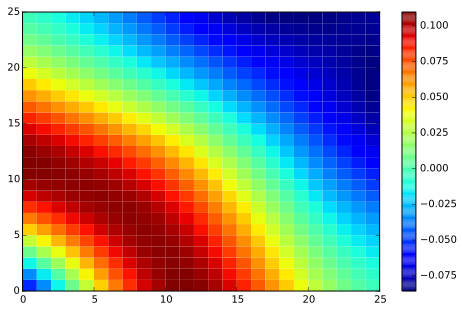

In [45]:
# compare sigma_T in T
data = sigma_T - x_T
plt.pcolor(data)
plt.colorbar() 

<matplotlib.colorbar.Colorbar instance at 0x00000000207A0EC8>

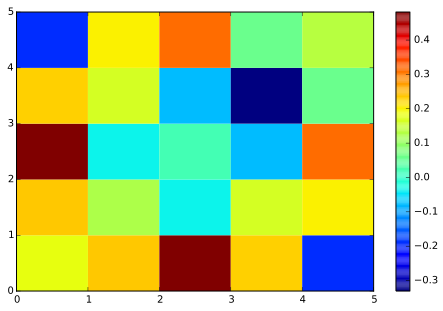

In [46]:
# compare sigma_N
data = sigma_N - x_N
plt.pcolor(data)
plt.colorbar() 

<matplotlib.colorbar.Colorbar instance at 0x0000000020F90388>

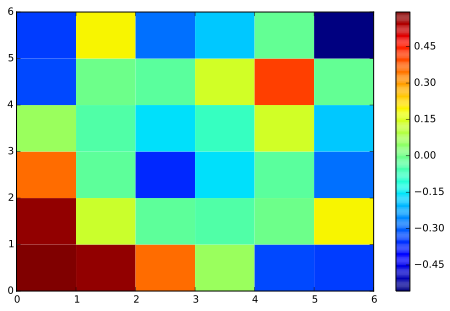

In [47]:
# compare sigma_C
data = sigma_C - x_C
plt.pcolor(data)
plt.colorbar() 

In [ ]:
Part 4: compare cov_N, cov_T, cov_C from data with ground truth
    
        use np.cov()
        
        We can see that there is more discrepancy in the diagonal of covariance (presented in anti-diagonal), but this is not     the case in the above figures (i.e. compare sigma_N). It may be due to cov(x) = (x-mean(x))(x-mean(x)).T/(n-1). The mean generated from data is not exact zero, altougth their expectation is. This may influence variance more than covariance.  

In [48]:
x_N = 0 # estimate of sigma_N
x_T = 0 # estimate of sigma_T
x_C = 0 # estimate of sigma_C

for i in xrange(1, 1000):
    x = np.random.multivariate_normal(np.zeros(t.size*n.size*c.size), np.kron(W,np.kron(U.T,V.T)), 1)
    
    # reshape
    z = x.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # covariance along cancer c
    nn = float(c.size)
    a = z[0,:,:].ravel()
    # flatten t, n axis
    for i in np.arange(1,nn):
        a = np.vstack((a, z[i,:,:].ravel()))
    x_C = x_C + np.cov(a)
    
 
   # covariance along number of samples n
    nn = float(n.size)
    
    b = z[:,0,:].ravel()
    # flatten t, c axis
    for i in np.arange(1,nn):
        b = np.vstack((b, z[:,i,:].ravel()))
    x_N = x_N + np.cov(b)
    
    # covariance along time (t)
    nn = float(t.size)
    d = z[:,:,0].ravel()
    # flatten n, c axis
    for i in np.arange(1,nn):
        d = np.vstack((d, z[:,:,i].ravel()))
    x_T = x_T + np.cov(d)
    
     
x_N = x_N/1000
x_T = x_T/1000
x_C = x_C/1000

 C:\Users\Ruoxi\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: RuntimeWarning:covariance is not positive-semidefinite.


<matplotlib.colorbar.Colorbar instance at 0x000000002146A6C8>

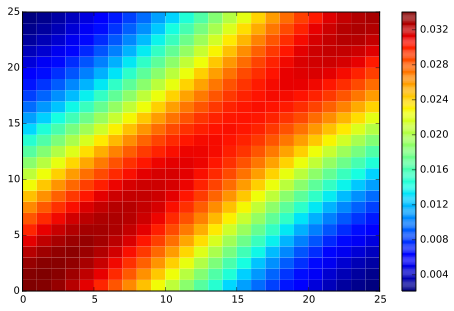

In [49]:
# covariance in T
data = cov_T - x_T
plt.pcolor(data)
plt.colorbar() 

<matplotlib.colorbar.Colorbar instance at 0x00000000217C6088>

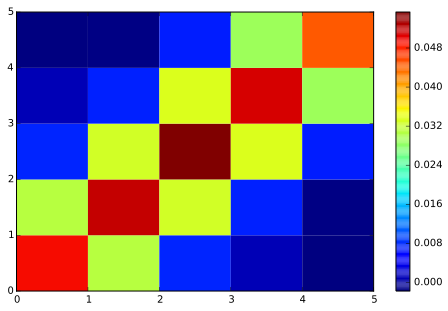

In [50]:
# caovariance in N
data = cov_N - x_N
plt.pcolor(data)
plt.colorbar() 

<matplotlib.colorbar.Colorbar instance at 0x00000000219C4988>

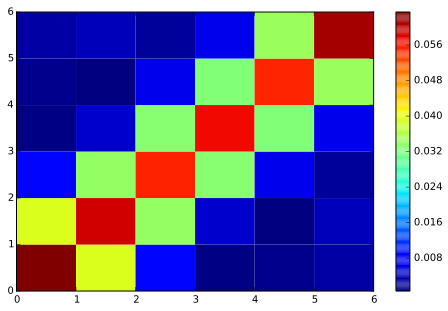

In [51]:
# covariance in C
data = cov_C - x_C
plt.pcolor(data)
plt.colorbar() 